In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPool2D

Using TensorFlow backend.


In [2]:
df = pd.read_csv('all_data.csv')
df[df['race_id'] == 202002020410]

,race_id,date,quarter,year,month,month_cos,month_sin,place,track,length,...,length_top3,direction_count,direction_win_score,direction_top3,win_score,jockey_id,jockey_weight,jockey_age,jockey_win_rate,jockey_win_count
0,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,0,0.000000,0,1.000,1015,50,42,0.18500,2
1,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1,1,0.500000,1,0.500,1091,47,34,0.16920,0
2,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,0,0.000000,0,0.333,5203,50,46,0.29270,0
3,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,0,0.000000,0,0.250,1032,45,40,0.22890,0
4,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1,2,0.666500,2,0.200,1127,47,29,0.21030,1
5,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,5,11,0.321182,5,0.167,1116,47,31,0.22120,3
6,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,0,0.000000,0,0.143,1163,44,23,0.19700,0
7,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,1,0.250000,0,0.125,1095,45,36,0.25980,0
8,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,1,0.125000,0,0.111,1176,46,19,0.04544,0
9,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,2,0.333500,1,0.100,5339,53,41,0.46850,2


In [3]:
# condition_2 = 0 if condition==0(良) else 1(稍重、重、不良)
def conv_condition(val):
    if val == 0:
        return val
    return 1
df['condition_2'] = pd.Series(np.vectorize(conv_condition)(df['condition']), index=df.index)

In [4]:
# attributions * race info
len_items = sorted(df['length'].unique().tolist())
age_items = sorted(df['age'].unique().tolist())

def conv_attr(val):
    return val * 2 - 1

def conv_course(track, attr):
    return (track-1) * conv_attr(attr)

def conv_length(len, attr):
    return np.cos(np.pi * len / len_items[-1]) * conv_attr(attr)

def conv_growth(age, attr):
    return np.cos(np.pi * age / age_items[-1] * conv_attr(attr))

def conv_condition(cond, attr):
    if cond == 0:
        return 0
    if cond == 1:
        return conv_attr(attr) / 2
    return conv_attr(attr)

df['attr_course*race'] = pd.Series(np.vectorize(conv_course)(df['track'], df['attr_course']), index=df.index)
df['attr_length*race'] = pd.Series(np.vectorize(conv_length)(df['length'], df['attr_length']), index=df.index)
df['attr_leg*race'] = pd.Series(np.vectorize(conv_attr)(df['attr_leg']), index=df.index)
df['attr_growth*race'] = pd.Series(np.vectorize(conv_growth)(df['age'], df['attr_growth']), index=df.index)
df['attr_condition*race'] = pd.Series(np.vectorize(conv_condition)(df['condition_2'], df['attr_condition']), index=df.index)

# 馬体重に対する騎手体重の比率
df['weight_par_horse'] = df['jockey_weight'] / df['weight']
df['weight_par_horse'] = df['weight_par_horse'].replace(float('inf'), 0)

In [5]:
# 血統データのパーセンテージ化
def conv_res_rate(target, other_1, other_2, other_3):
    if (target + other_1 + other_2 + other_3) == 0:
        return 0.0
    return target / (target + other_1 + other_2 + other_3)

df['f_res_1st'] = pd.Series(np.vectorize(conv_res_rate)(df['f_res_1st'], df['f_res_2nd'], df['f_res_3rd'], df['f_res_lose']), index=df.index).astype(np.float32)
df['f_res_2nd'] = pd.Series(np.vectorize(conv_res_rate)(df['f_res_2nd'], df['f_res_1st'], df['f_res_3rd'], df['f_res_lose']), index=df.index).astype(np.float32)
df['f_res_3rd'] = pd.Series(np.vectorize(conv_res_rate)(df['f_res_3rd'], df['f_res_1st'], df['f_res_2nd'], df['f_res_lose']), index=df.index).astype(np.float32)
df['f_res_lose'] = pd.Series(np.vectorize(conv_res_rate)(df['f_res_lose'], df['f_res_1st'], df['f_res_2nd'], df['f_res_3rd']), index=df.index).astype(np.float32)
df['mf_res_1st'] = pd.Series(np.vectorize(conv_res_rate)(df['mf_res_1st'], df['mf_res_2nd'], df['mf_res_3rd'], df['mf_res_lose']), index=df.index).astype(np.float32)
df['mf_res_2nd'] = pd.Series(np.vectorize(conv_res_rate)(df['mf_res_2nd'], df['mf_res_1st'], df['mf_res_3rd'], df['mf_res_lose']), index=df.index).astype(np.float32)
df['mf_res_3rd'] = pd.Series(np.vectorize(conv_res_rate)(df['mf_res_3rd'], df['mf_res_1st'], df['mf_res_2nd'], df['mf_res_lose']), index=df.index).astype(np.float32)
df['mf_res_lose'] = pd.Series(np.vectorize(conv_res_rate)(df['mf_res_lose'], df['mf_res_1st'], df['mf_res_2nd'], df['mf_res_3rd']), index=df.index).astype(np.float32)

In [6]:
df[df['race_id'] == 202002020410]

,race_id,date,quarter,year,month,month_cos,month_sin,place,track,length,...,jockey_weight,jockey_age,jockey_win_rate,jockey_win_count,condition_2,attr_course*race,attr_length*race,attr_leg*race,attr_growth*race,attr_condition*race
0,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,50,42,0.18500,2,0,-0.0000,0.631706,1.0000,1.000000,0
1,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,47,34,0.16920,0,0,-1.0000,0.631706,0.0000,0.280549,0
2,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,50,46,0.29270,0,0,-0.0000,-0.000000,0.0000,1.000000,0
3,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,45,40,0.22890,0,0,-0.0000,-0.000000,0.0000,1.000000,0
4,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,47,29,0.21030,1,0,-0.0000,-0.000000,0.0000,1.000000,0
5,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,47,31,0.22120,3,0,-0.0000,-0.000000,0.0000,1.000000,0
6,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,44,23,0.19700,0,0,-0.0000,-0.000000,0.0000,1.000000,0
7,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,45,36,0.25980,0,0,-0.0000,-0.000000,0.0000,1.000000,0
8,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,46,19,0.04544,0,0,-0.0000,-0.000000,0.0000,1.000000,0
9,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,53,41,0.46850,2,0,-1.0000,0.465378,-0.6380,0.863765,0


In [7]:
# 学習に使用するカラム
cols = ['length', 'direction',
        #'weather', 'condition', 'horse_num',
        'horse_num_2', 'jockey_id', #'popularity',
        'sex', 'age', 'trainer', 'prize_center', 'prize_region',
        'attr_course*race', 'attr_length*race', 'attr_leg*race', 'attr_growth*race', 'attr_condition*race', 'condition_2',
        'f_res_1st', 'f_res_2nd', 'f_res_3rd', 'f_res_lose',
        'mf_res_1st', 'mf_res_2nd', 'mf_res_3rd', 'mf_res_lose', 'weight', 'jockey_weight', 'jockey_age', 'total_count', 'total_score', 'total_top3',
        'place_count', 'place_win_score', 'place_top3', 'length_count', 'length_win_score', 'length_top3', 'direction_count', 'direction_win_score',
        'direction_top3',
        # 'quarter', 'year', 'month', 
        'month_cos', 'month_sin', 'weather*condition', 'jockey_win_rate', 'jockey_win_count', 'weight_par_horse']

### CNN

In [8]:
# 正規化

from sklearn import preprocessing

def scaring(df):
    df_scr = df.copy()
    mm = preprocessing.StandardScaler()
    for col in cols:
        if col in ['month_cos', 'month_sin', 'track', 'horse_num_2', 'attr_course*race', 'attr_length*race', 'attr_leg*race',
                  'attr_growth*race', 'attr_condition*race', 'condition_2']:
            # 除外
            continue
        df_scr[col] = mm.fit_transform(df_scr[col].values.reshape(-1, 1))
    return df_scr

df_scr = scaring(df)
df_scr.head()

,race_id,date,quarter,year,month,month_cos,month_sin,place,track,length,...,jockey_weight,jockey_age,jockey_win_rate,jockey_win_count,condition_2,attr_course*race,attr_length*race,attr_leg*race,attr_growth*race,attr_condition*race
0,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2.329787,...,0.804397,0.971140,-0.259049,2.465503,0,-0.0,0.631706,1.0,1.000000,0
1,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2.329787,...,-0.408155,0.020584,-0.405260,-0.443852,0,-1.0,0.631706,0.0,0.280549,0
2,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2.329787,...,0.804397,1.446419,0.737596,-0.443852,0,-0.0,-0.000000,0.0,1.000000,0
3,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2.329787,...,-1.216522,0.733501,0.147197,-0.443852,0,-0.0,-0.000000,0.0,1.000000,0
4,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2.329787,...,-0.408155,-0.573513,-0.024925,1.010825,0,-0.0,-0.000000,0.0,1.000000,0


In [9]:
# データ準備
df_train = df_scr[df_scr['date'] < '2019-07-01']
df_test = df_scr[df_scr['date'] >= '2019-07-01']
x_train = np.array(df_train[cols])
y_train = np.array(df_train['is_top3'])
x_test = np.array(df_test[cols])
y_test = np.array(df_test['is_top3'])

# モデル定義
model_cnn = Sequential()
model_cnn.add(Dense(320, activation='tanh', input_dim=len(cols)))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(320, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(160, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(1,activation='sigmoid'))

# 結合
model_cnn.compile(optimizer=keras.optimizers.SGD(lr=0.01), 
          loss='binary_crossentropy',
          metrics=['accuracy', 'binary_crossentropy'])

# 学習
epoc = 400
hist = model_cnn.fit(
          x_train,
          y_train,
          epochs=epoc,
          batch_size=100,
          validation_data=(x_train, y_train),
          verbose=0)

In [10]:
# 予測
score = model_cnn.evaluate(x_test, y_test, batch_size=100)
print('Test Data loss:', score[0])
print('Test Data accuracy:', score[1])

y_pred_cnn = model_cnn.predict_classes(x_test).reshape(1, len(df_test))
df_pred_cnn = pd.DataFrame({'race_id':df_test['race_id'],
                            'target':df_test['is_top3'],
                            'target_pred':y_pred_cnn[0]})

df_pred_cnn['is_correct'] = pd.Series(np.vectorize(lambda x, y: 1 if x==y else 0)(df_pred_cnn['target'], df_pred_cnn['target_pred']), index=df_pred_cnn.index)

display(df_pred_cnn[df_pred_cnn['race_id'] == 202002020410])

8370/8370 [==============================] - 0s 15us/step
Test Data loss: 0.4588321875714059
Test Data accuracy: 0.7904420495033264


,race_id,target,target_pred,is_correct
0,202002020410,1,0,0
1,202002020410,1,0,0
2,202002020410,1,0,0
3,202002020410,0,0,1
4,202002020410,0,0,1
5,202002020410,0,0,1
6,202002020410,0,0,1
7,202002020410,0,0,1
8,202002020410,0,0,1
9,202002020410,0,0,1


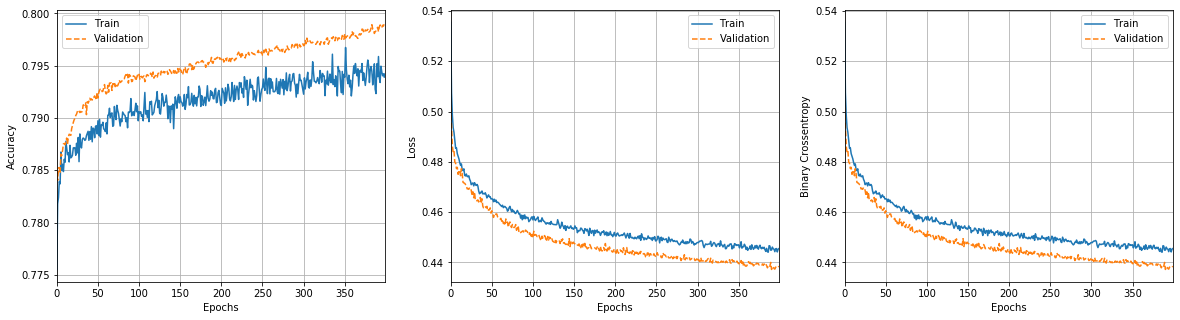

In [11]:
# 学習過程可視化
def plot_history(history):
    fig = plt.figure(figsize=(20,5))
    for i, key in enumerate(['accuracy', 'loss', 'binary_crossentropy']):
        ax = fig.add_subplot(1, 3, i+1)
        ax.plot(history.epoch, history.history[key], label='Train')
        ax.plot(history.epoch, history.history[f'val_{key}'], '--', label='Validation')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(key.replace('_',' ').title())
        ax.grid(True)
        ax.legend()
        ax.set_xlim([0,max(history.epoch)])

plot_history(hist)

### LightGBM

In [12]:
df_train = df[df['date'] < '2019-07-01']
df_test = df[df['date'] >= '2019-07-01']

sm = SMOTE(random_state=42)
X, Y = sm.fit_sample(df_train[cols], df_train['is_top3'])


# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X, Y)
lgb_eval = lgb.Dataset(df_test[cols], df_test['is_top3'], reference=lgb_train)

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',      # 目的 : 2クラス分類
        'metric': {'binary_error'}, # 評価指標 : 誤り率(= 1-正答率)
        'learning_rate' : 0.25,     # 試したもの：1e-5, 1e-3, 1e-2, 1e-1
        'n_estimators' : 20,        # 試したもの：10, 50, 100, 250
        'max_depth' : 4,            # 試したもの：3, 4, 5, 6, 10
}

# モデルの学習
model_lgbm = lgb.train(params,
                train_set=lgb_train, # トレーニングデータの指定
                valid_sets=lgb_eval, # 検証データの指定
                early_stopping_rounds=5,
                verbose_eval=50,
)

C:\Users\ayane hara\anaconda3\envs\new\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_error: 0.214934


In [13]:
# テストデータの予測 (クラス1の予測確率(クラス1である確率)を返す)
y_pred_prob_lgbm = model_lgbm.predict(df_test[cols])
# テストデータの予測 (予測クラス(0 or 1)を返す)
y_pred_lgbm = np.where(y_pred_prob_lgbm < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

# モデル評価
# acc : 正答率
acc = metrics.accuracy_score(df_test['is_top3'],y_pred_lgbm)
# logloss 
logloss = metrics.log_loss(df_test['is_top3'],y_pred_prob_lgbm)
# AUC 
auc = metrics.roc_auc_score(df_test['is_top3'],y_pred_prob_lgbm)

# 真値と予測値の表示
df_pred_lgbm = pd.DataFrame({'race_id':df_test['race_id'],
                             'target':df_test['is_top3'],
                             'target_pred':y_pred_lgbm,
                             'target0_prob':1-y_pred_prob_lgbm,
                             'target1_prob':y_pred_prob_lgbm})

print(f'Acc = {acc}, logloss = {logloss}, AUC = {auc}')
display(df_pred_lgbm[df_pred_lgbm['race_id'] == 202002020410])

Acc = 0.7850657108721625, logloss = 0.4743894148646602, AUC = 0.718320351864408


,race_id,target,target_pred,target0_prob,target1_prob
0,202002020410,1,0,0.846442,0.153558
1,202002020410,1,0,0.701479,0.298521
2,202002020410,1,0,0.723228,0.276772
3,202002020410,0,0,0.783501,0.216499
4,202002020410,0,0,0.773150,0.226850
5,202002020410,0,0,0.843704,0.156296
6,202002020410,0,0,0.773516,0.226484
7,202002020410,0,0,0.753756,0.246244
8,202002020410,0,0,0.830300,0.169700
9,202002020410,0,0,0.762748,0.237252


In [14]:
# 予測値について、上位3件をtrueとするカラムtarget_pred_2を追加
def get_pred(race, prob):
    probs = df_pred_lgbm[df_pred_lgbm['race_id'] == race]['target1_prob'].values.tolist()
    probs.sort(reverse=True)
    if probs.index(prob) < 3:
        return 1
    return 0
df_pred_lgbm['target_pred_2'] = pd.Series(np.vectorize(get_pred)(df_pred_lgbm['race_id'], df_pred_lgbm['target1_prob']), index=df_pred_lgbm.index)

acc = metrics.accuracy_score(df_pred_lgbm['target'], df_pred_lgbm['target_pred_2'])
print('Acc =', acc)

display(df_pred_lgbm[df_pred_lgbm['race_id'] == 202002020410])

Acc = 0.7837514934289128


,race_id,target,target_pred,target0_prob,target1_prob,target_pred_2
0,202002020410,1,0,0.846442,0.153558,0
1,202002020410,1,0,0.701479,0.298521,1
2,202002020410,1,0,0.723228,0.276772,1
3,202002020410,0,0,0.783501,0.216499,0
4,202002020410,0,0,0.773150,0.226850,0
5,202002020410,0,0,0.843704,0.156296,0
6,202002020410,0,0,0.773516,0.226484,0
7,202002020410,0,0,0.753756,0.246244,1
8,202002020410,0,0,0.830300,0.169700,0
9,202002020410,0,0,0.762748,0.237252,0


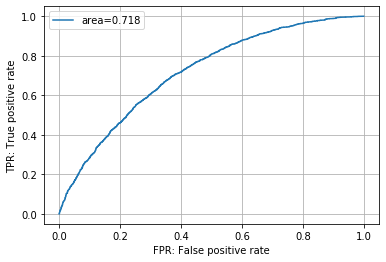

In [15]:
# TPR * FPR 可視化
# -> areaが1に近いほどGOOD
y_pred_prob_lgbm = model_lgbm.predict(df_test[cols])

fpr, tpr, thresholds = metrics.roc_curve(df_test['is_top3'], y_pred_prob_lgbm)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'area={round(auc, 3)}')

plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()

,feature,importance
7,prize_center,0.218855
38,month_cos,0.188552
39,month_sin,0.154882
5,age,0.094276
41,jockey_win_rate,0.060606
26,total_count,0.037037
35,direction_count,0.023569
3,jockey_id,0.023569
30,place_win_score,0.023569
12,attr_growth*race,0.023569


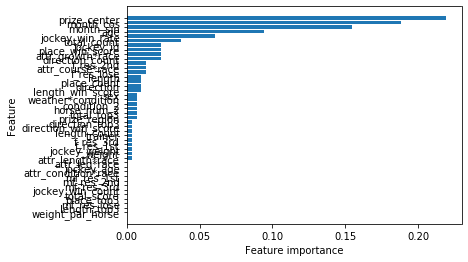

In [16]:
# 特徴量の重要度可視化
def plot_feature_importance(df): 
    n_features = len(df)
    df_plot = df.sort_values('importance')
    f_imoprtance_plot = df_plot['importance'].values
    plt.barh(range(n_features), f_imoprtance_plot, align='center') 
    cols_plot = df_plot['feature'].values
    plt.yticks(np.arange(n_features), cols_plot)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

f_importance = np.array(model_lgbm.feature_importance())
f_importance = f_importance / np.sum(f_importance)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False)
display(df_importance)

plot_feature_importance(df_importance)